In [1]:
import os
import time
import json
from typing import List, Dict, Any, Tuple, Optional
from itertools import product

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
if not OPENAI_API_KEY:
    raise ValueError("Set OPENAI_API_KEY in environment or .env file.")

EMBEDDING_MODEL = "text-embedding-3-small"
LLM_MODEL = "gpt-4.1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

/Users/ebpearls1/Desktop/Advanced-RAG-demo/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Load Reranker Model

In [2]:
RERANKER_MODEL_NAME = "BAAI/bge-reranker-base"

tokenizer = AutoTokenizer.from_pretrained(RERANKER_MODEL_NAME)
reranker_model = AutoModelForSequenceClassification.from_pretrained(RERANKER_MODEL_NAME).to(DEVICE)

def cross_encoder_rerank(
    query: str,
    docs: List[Document],
    top_k: int = 5
) -> List[Document]:
    if not docs:
        return []

    pairs = [(query, d.page_content) for d in docs]
    inputs = tokenizer(
        [p[0] for p in pairs],
        [p[1] for p in pairs],
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    ).to(DEVICE)

    with torch.no_grad():
        scores = reranker_model(**inputs).logits.squeeze(-1).cpu().numpy()

    ranked_idx = np.argsort(-scores)
    top_docs = [docs[i] for i in ranked_idx[:top_k]]
    return top_docs

## Helper Functions

In [3]:
def get_embedding_model() -> OpenAIEmbeddings:
    return OpenAIEmbeddings(model=EMBEDDING_MODEL, api_key=OPENAI_API_KEY)

def get_llm(model_name: str = LLM_MODEL, temperature: float = 0.0) -> ChatOpenAI:
    return ChatOpenAI(
        model=model_name,
        temperature=temperature,
        api_key=OPENAI_API_KEY,
    )

def load_squad_subset(max_examples: int = 1000) -> Tuple[List[Document], pd.DataFrame]:
    ds = load_dataset("squad", split="train[:10%]")
    ds = ds.shuffle(seed=42).select(range(min(max_examples, len(ds))))

    contexts = []
    qa_rows = []

    for ex in ds:
        context = ex["context"]
        q = ex["question"]
        ans_texts = ex["answers"]["text"]
        ans = ans_texts[0] if ans_texts else ""

        contexts.append(context)
        qa_rows.append({
            "id": ex["id"],
            "context": context,
            "question": q,
            "answer": ans
        })

    unique_contexts = list({c: True for c in contexts}.keys())
    docs = [Document(page_content=c, metadata={"source": f"squad_paragraph_{i}"})
            for i, c in enumerate(unique_contexts)]

    qa_df = pd.DataFrame(qa_rows)
    return docs, qa_df

## Load Dataset

In [4]:
base_docs, qa_df = load_squad_subset(max_examples=600)
print(f"Loaded {len(base_docs)} documents and {len(qa_df)} QA pairs")

# Sample a small test set for efficient optimization
test_qa = qa_df.sample(min(10, len(qa_df)), random_state=42)
print(f"Using {len(test_qa)} QA pairs for evaluation")

Loaded 496 documents and 600 QA pairs
Using 10 QA pairs for evaluation


## Build Vectorstore with Custom Parameters

In [5]:
def build_vectorstore(
    docs: List[Document],
    chunk_size: int,
    chunk_overlap: int
) -> Tuple[FAISS, List[Document]]:
    """Build a vectorstore with specified chunking parameters."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""],
    )
    chunks = splitter.split_documents(docs)
    
    embeddings = get_embedding_model()
    vectordb = FAISS.from_documents(chunks, embedding=embeddings)
    return vectordb, chunks

## RAG Pipeline Functions

In [6]:
def retrieve_and_rerank(
    vectordb: FAISS,
    query: str,
    stage1_k: int,
    top_k_reranked: int
) -> List[Document]:
    """Retrieve documents and rerank them."""
    # Stage 1: Initial retrieval
    candidates = vectordb.similarity_search(query, k=stage1_k)
    
    # Stage 2: Reranking
    top_docs = cross_encoder_rerank(query, candidates, top_k=top_k_reranked)
    return top_docs

def generate_answer(query: str, docs: List[Document]) -> str:
    """Generate an answer from retrieved documents."""
    if not docs:
        return "No relevant documents found."
    
    llm = get_llm()
    context = "\n\n".join([d.page_content for d in docs])
    
    system_msg = (
        "You are a question answering system. Use ONLY the provided context to answer. "
        "If the answer is not in the context, say you don't know."
    )
    
    prompt = f"""Context:
\"\"\"{context}\"\"\"

Question: {query}

Answer based only on the context above:"""
    
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user", "content": prompt}
    ]
    
    resp = llm.invoke(messages)
    return resp.content.strip()

def evaluate_answer(
    query: str,
    answer: str,
    ground_truth: str
) -> Dict[str, Any]:
    """Evaluate answer quality using LLM judge."""
    llm = get_llm()
    
    system_msg = (
        "You are an evaluation assistant. Score the model's answer on:\n"
        "- correctness: is it factually correct vs ground truth? (1-5)\n"
        "- relevance: is it focused on the question? (1-5)\n"
        "Return a JSON object with keys: correctness, relevance"
    )
    
    user_prompt = f"""Question: {query}
Ground truth: {ground_truth}
Model answer: {answer}

Output JSON:
{{
  "correctness": 1-5,
  "relevance": 1-5
}}"""
    
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user", "content": user_prompt}
    ]
    
    resp = llm.invoke(messages)
    raw = resp.content.strip()
    
    try:
        data = json.loads(raw)
    except Exception:
        start = raw.find("{")
        end = raw.rfind("}")
        if start != -1 and end != -1:
            try:
                data = json.loads(raw[start:end+1])
            except Exception:
                data = {"correctness": 3, "relevance": 3}
        else:
            data = {"correctness": 3, "relevance": 3}
    
    return {
        "correctness": int(data.get("correctness", 3)),
        "relevance": int(data.get("relevance", 3))
    }

## Run Single Configuration

In [7]:
def evaluate_configuration(
    docs: List[Document],
    qa_pairs: pd.DataFrame,
    chunk_size: int,
    chunk_overlap: int,
    stage1_k: int,
    top_k_reranked: int,
    verbose: bool = False
) -> Dict[str, Any]:
    """Evaluate a single configuration of parameters."""
    
    if verbose:
        print(f"\nTesting: chunk_size={chunk_size}, chunk_overlap={chunk_overlap}, "
              f"stage1_k={stage1_k}, top_k={top_k_reranked}")
    
    # Build vectorstore
    start_time = time.time()
    vectordb, chunks = build_vectorstore(docs, chunk_size, chunk_overlap)
    build_time = time.time() - start_time
    
    # Run evaluation on test set
    scores = []
    total_latency = 0
    
    for _, row in qa_pairs.iterrows():
        query = row["question"]
        gt = row["answer"]
        
        # Retrieve and generate
        t0 = time.time()
        top_docs = retrieve_and_rerank(vectordb, query, stage1_k, top_k_reranked)
        answer = generate_answer(query, top_docs)
        latency = time.time() - t0
        
        # Evaluate
        eval_result = evaluate_answer(query, answer, gt)
        scores.append(eval_result)
        total_latency += latency
    
    # Aggregate metrics
    avg_correctness = np.mean([s["correctness"] for s in scores])
    avg_relevance = np.mean([s["relevance"] for s in scores])
    avg_latency = total_latency / len(qa_pairs) * 1000  # ms
    
    result = {
        "chunk_size": chunk_size,
        "chunk_overlap": chunk_overlap,
        "overlap_ratio": chunk_overlap / chunk_size,
        "stage1_k": stage1_k,
        "top_k_reranked": top_k_reranked,
        "num_chunks": len(chunks),
        "avg_correctness": avg_correctness,
        "avg_relevance": avg_relevance,
        "avg_latency_ms": avg_latency,
        "build_time_s": build_time,
        "combined_score": (avg_correctness + avg_relevance) / 2
    }
    
    if verbose:
        print(f"  Chunks: {len(chunks)}, Correctness: {avg_correctness:.2f}, "
              f"Relevance: {avg_relevance:.2f}, Latency: {avg_latency:.0f}ms")
    
    return result

## Define Parameter Grid

We'll test combinations of:
- **chunk_size**: [200, 400, 600, 800]
- **chunk_overlap**: [20%, 30%, 40% of chunk_size]
- **stage1_k**: [20, 30, 50]
- **top_k_reranked**: [3, 5, 10]

In [8]:
# Define parameter grid
chunk_sizes = [200, 400, 600, 800]
overlap_ratios = [0.2, 0.3, 0.4]  # 20%, 30%, 40%
stage1_k_values = [20, 30, 50]
top_k_values = [3, 5, 10]

# Generate all combinations
param_grid = []
for cs in chunk_sizes:
    for ratio in overlap_ratios:
        overlap = int(cs * ratio)
        for k1 in stage1_k_values:
            for k2 in top_k_values:
                if k2 <= k1:  # top_k should be <= stage1_k
                    param_grid.append({
                        "chunk_size": cs,
                        "chunk_overlap": overlap,
                        "stage1_k": k1,
                        "top_k_reranked": k2
                    })

print(f"Total configurations to test: {len(param_grid)}")
print(f"\nExample configurations:")
for i in range(min(5, len(param_grid))):
    print(f"  {param_grid[i]}")

Total configurations to test: 108

Example configurations:
  {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 20, 'top_k_reranked': 3}
  {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 20, 'top_k_reranked': 5}
  {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 20, 'top_k_reranked': 10}
  {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 30, 'top_k_reranked': 3}
  {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 30, 'top_k_reranked': 5}


## Run Grid Search

**Note**: This will take some time depending on the number of configurations. 
You can reduce the test set size or parameter grid for faster results.

In [9]:
# Run grid search
results = []

print(f"Starting grid search over {len(param_grid)} configurations...\n")

for i, params in enumerate(param_grid, 1):
    print(f"[{i}/{len(param_grid)}] Testing config: {params}")
    
    result = evaluate_configuration(
        docs=base_docs,
        qa_pairs=test_qa,
        chunk_size=params["chunk_size"],
        chunk_overlap=params["chunk_overlap"],
        stage1_k=params["stage1_k"],
        top_k_reranked=params["top_k_reranked"],
        verbose=True
    )
    
    results.append(result)

print("\nGrid search complete!")

Starting grid search over 108 configurations...

[1/108] Testing config: {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 20, 'top_k_reranked': 3}

Testing: chunk_size=200, chunk_overlap=40, stage1_k=20, top_k=3
  Chunks: 2563, Correctness: 4.90, Relevance: 5.00, Latency: 2841ms
[2/108] Testing config: {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 20, 'top_k_reranked': 5}

Testing: chunk_size=200, chunk_overlap=40, stage1_k=20, top_k=5
  Chunks: 2563, Correctness: 4.90, Relevance: 5.00, Latency: 2549ms
[3/108] Testing config: {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 20, 'top_k_reranked': 10}

Testing: chunk_size=200, chunk_overlap=40, stage1_k=20, top_k=10
  Chunks: 2563, Correctness: 4.90, Relevance: 5.00, Latency: 2509ms
[4/108] Testing config: {'chunk_size': 200, 'chunk_overlap': 40, 'stage1_k': 30, 'top_k_reranked': 3}

Testing: chunk_size=200, chunk_overlap=40, stage1_k=30, top_k=3
  Chunks: 2563, Correctness: 4.90, Relevance: 5.00, Latency: 2896ms
[5/108] T

## Analyze Results

In [10]:
# Create results dataframe
results_df = pd.DataFrame(results)

# Sort by combined score
results_df = results_df.sort_values("combined_score", ascending=False)

print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS")
print("="*80)

display_cols = [
    "chunk_size", "chunk_overlap", "overlap_ratio",
    "stage1_k", "top_k_reranked", "num_chunks",
    "avg_correctness", "avg_relevance", "combined_score", "avg_latency_ms"
]

display(results_df[display_cols].head(10))

# Best configuration
best_config = results_df.iloc[0]
print("\n" + "="*80)
print("BEST CONFIGURATION")
print("="*80)
print(f"Chunk Size: {best_config['chunk_size']}")
print(f"Chunk Overlap: {best_config['chunk_overlap']} ({best_config['overlap_ratio']:.1%})")
print(f"Stage 1 K: {best_config['stage1_k']}")
print(f"Top K Reranked: {best_config['top_k_reranked']}")
print(f"\nPerformance:")
print(f"  Correctness: {best_config['avg_correctness']:.2f}/5.0")
print(f"  Relevance: {best_config['avg_relevance']:.2f}/5.0")
print(f"  Combined Score: {best_config['combined_score']:.2f}/5.0")
print(f"  Avg Latency: {best_config['avg_latency_ms']:.0f}ms")
print(f"  Num Chunks: {best_config['num_chunks']}")


TOP 10 CONFIGURATIONS


,chunk_size,chunk_overlap,overlap_ratio,stage1_k,top_k_reranked,num_chunks,avg_correctness,avg_relevance,combined_score,avg_latency_ms
107,800,320,0.4,50,10,683,5.0,5.0,5.0,11119.534659
89,800,160,0.2,50,10,672,5.0,5.0,5.0,13447.645760
26,200,80,0.4,50,10,2638,5.0,5.0,5.0,5110.974479
87,800,160,0.2,50,3,672,5.0,5.0,5.0,12009.182596
86,800,160,0.2,30,10,672,5.0,5.0,5.0,6558.825016
29,400,80,0.2,20,10,1272,5.0,5.0,5.0,3903.359270
61,600,120,0.2,50,5,859,5.0,5.0,5.0,8934.968185
84,800,160,0.2,30,3,672,5.0,5.0,5.0,7031.577444
82,800,160,0.2,20,5,672,5.0,5.0,5.0,5030.266309
35,400,80,0.2,50,10,1272,5.0,5.0,5.0,8547.840881



BEST CONFIGURATION
Chunk Size: 800.0
Chunk Overlap: 320.0 (40.0%)
Stage 1 K: 50.0
Top K Reranked: 10.0

Performance:
  Correctness: 5.00/5.0
  Relevance: 5.00/5.0
  Combined Score: 5.00/5.0
  Avg Latency: 11120ms
  Num Chunks: 683.0


## Visualization: Parameter Impact

/var/folders/1w/cdvfx941205597f7k7hc85xr0000gn/T/ipykernel_5078/3953689701.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x*100)}%' for x in overlap_impact['overlap_ratio']])


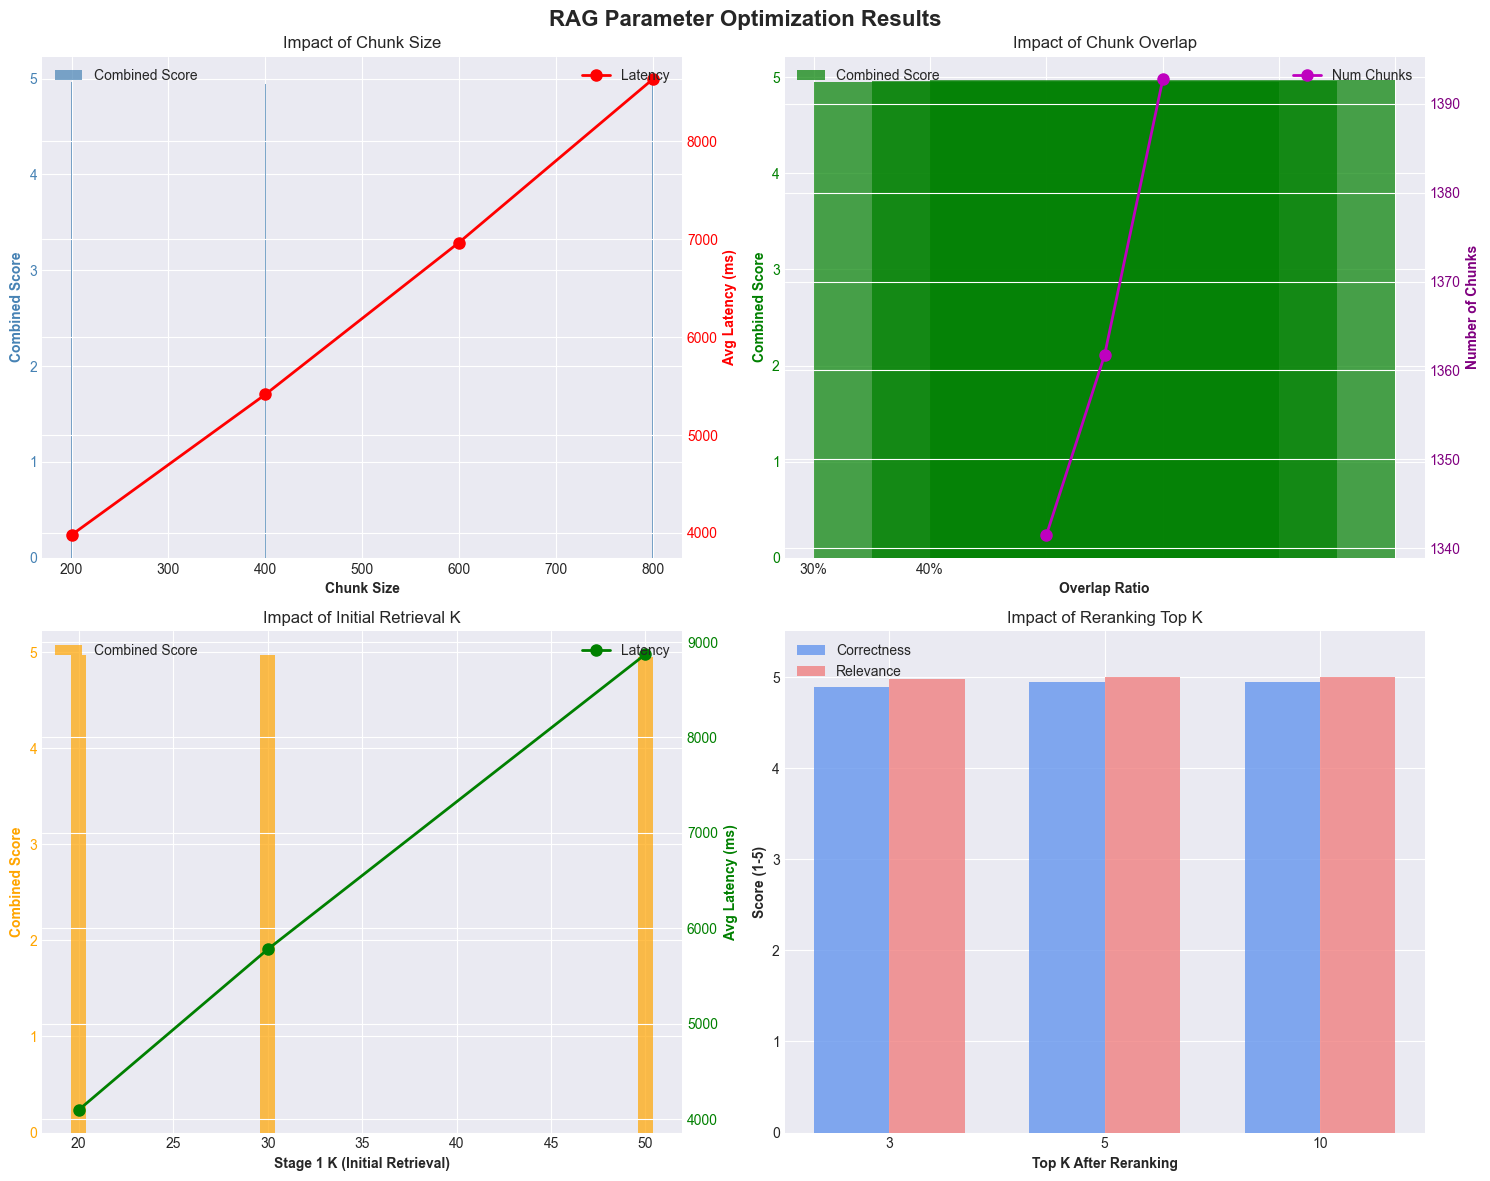

In [11]:
# Set up plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('RAG Parameter Optimization Results', fontsize=16, fontweight='bold')

# 1. Chunk Size Impact
ax = axes[0, 0]
chunk_impact = results_df.groupby('chunk_size').agg({
    'combined_score': 'mean',
    'avg_latency_ms': 'mean'
}).reset_index()

ax2 = ax.twinx()
ax.bar(chunk_impact['chunk_size'], chunk_impact['combined_score'], 
       alpha=0.7, color='steelblue', label='Combined Score')
ax2.plot(chunk_impact['chunk_size'], chunk_impact['avg_latency_ms'], 
         'ro-', linewidth=2, markersize=8, label='Latency')

ax.set_xlabel('Chunk Size', fontweight='bold')
ax.set_ylabel('Combined Score', fontweight='bold', color='steelblue')
ax2.set_ylabel('Avg Latency (ms)', fontweight='bold', color='red')
ax.set_title('Impact of Chunk Size')
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='red')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 2. Chunk Overlap Impact
ax = axes[0, 1]
overlap_impact = results_df.groupby('overlap_ratio').agg({
    'combined_score': 'mean',
    'num_chunks': 'mean'
}).reset_index()

ax2 = ax.twinx()
ax.bar(overlap_impact['overlap_ratio'], overlap_impact['combined_score'], 
       alpha=0.7, color='green', label='Combined Score')
ax2.plot(overlap_impact['overlap_ratio'], overlap_impact['num_chunks'], 
         'mo-', linewidth=2, markersize=8, label='Num Chunks')

ax.set_xlabel('Overlap Ratio', fontweight='bold')
ax.set_ylabel('Combined Score', fontweight='bold', color='green')
ax2.set_ylabel('Number of Chunks', fontweight='bold', color='purple')
ax.set_title('Impact of Chunk Overlap')
ax.set_xticklabels([f'{int(x*100)}%' for x in overlap_impact['overlap_ratio']])
ax.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='purple')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 3. Stage1 K Impact
ax = axes[1, 0]
k_impact = results_df.groupby('stage1_k').agg({
    'combined_score': 'mean',
    'avg_latency_ms': 'mean'
}).reset_index()

ax2 = ax.twinx()
ax.bar(k_impact['stage1_k'], k_impact['combined_score'], 
       alpha=0.7, color='orange', label='Combined Score')
ax2.plot(k_impact['stage1_k'], k_impact['avg_latency_ms'], 
         'go-', linewidth=2, markersize=8, label='Latency')

ax.set_xlabel('Stage 1 K (Initial Retrieval)', fontweight='bold')
ax.set_ylabel('Combined Score', fontweight='bold', color='orange')
ax2.set_ylabel('Avg Latency (ms)', fontweight='bold', color='green')
ax.set_title('Impact of Initial Retrieval K')
ax.tick_params(axis='y', labelcolor='orange')
ax2.tick_params(axis='y', labelcolor='green')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 4. Top K Reranked Impact
ax = axes[1, 1]
topk_impact = results_df.groupby('top_k_reranked').agg({
    'avg_correctness': 'mean',
    'avg_relevance': 'mean'
}).reset_index()

width = 0.35
x = np.arange(len(topk_impact))
ax.bar(x - width/2, topk_impact['avg_correctness'], width, 
       alpha=0.8, label='Correctness', color='cornflowerblue')
ax.bar(x + width/2, topk_impact['avg_relevance'], width, 
       alpha=0.8, label='Relevance', color='lightcoral')

ax.set_xlabel('Top K After Reranking', fontweight='bold')
ax.set_ylabel('Score (1-5)', fontweight='bold')
ax.set_title('Impact of Reranking Top K')
ax.set_xticks(x)
ax.set_xticklabels(topk_impact['top_k_reranked'])
ax.legend()
ax.set_ylim([0, 5.5])

plt.tight_layout()
plt.show()

## Heatmap: Chunk Size vs Overlap

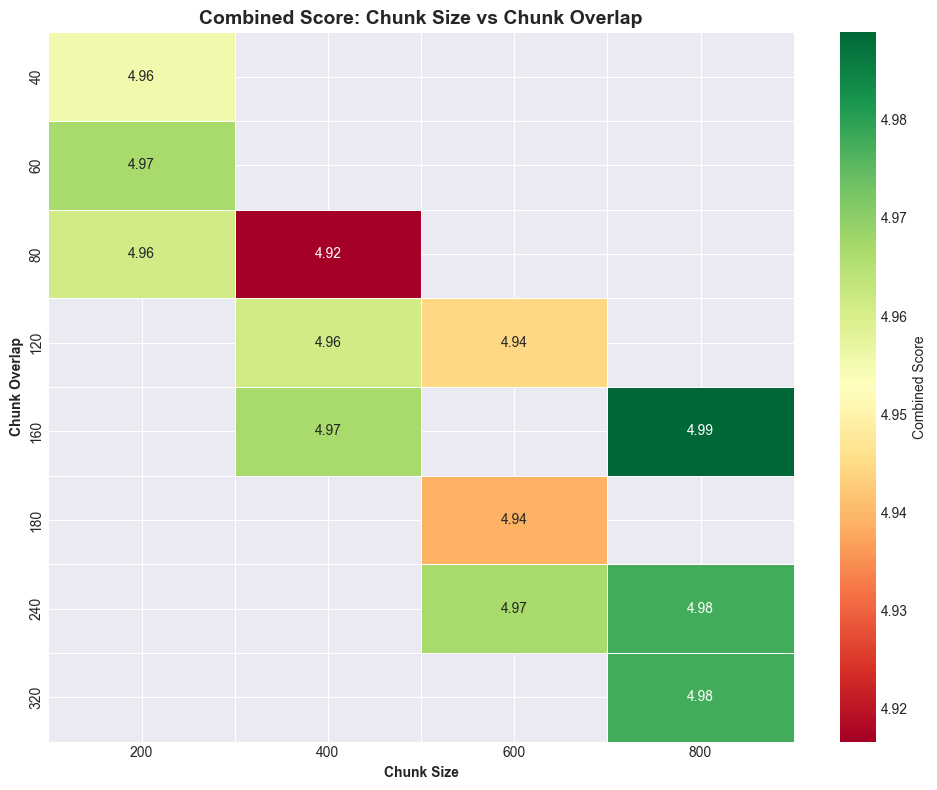

In [12]:
# Create pivot table for heatmap
pivot_data = results_df.groupby(['chunk_size', 'chunk_overlap'])['combined_score'].mean().reset_index()
pivot_table = pivot_data.pivot(index='chunk_overlap', columns='chunk_size', values='combined_score')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Combined Score'}, linewidths=0.5)
plt.title('Combined Score: Chunk Size vs Chunk Overlap', fontsize=14, fontweight='bold')
plt.xlabel('Chunk Size', fontweight='bold')
plt.ylabel('Chunk Overlap', fontweight='bold')
plt.tight_layout()
plt.show()

## Trade-off Analysis: Quality vs Latency

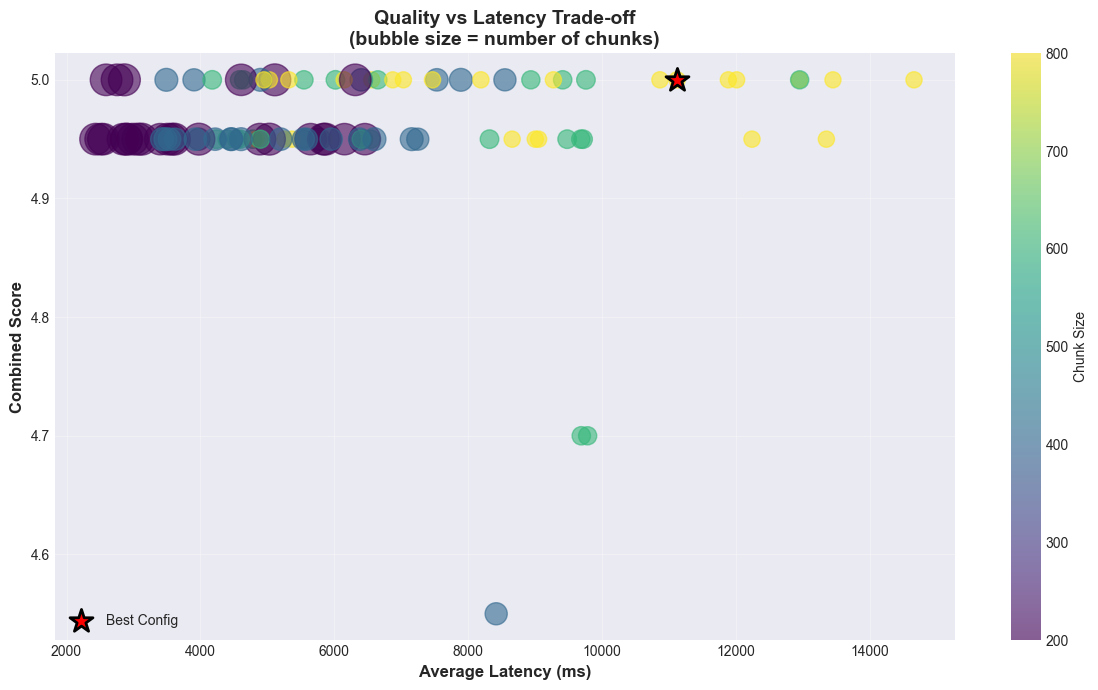

In [13]:
plt.figure(figsize=(12, 7))

# Color by chunk size
scatter = plt.scatter(results_df['avg_latency_ms'], 
                     results_df['combined_score'],
                     c=results_df['chunk_size'],
                     s=results_df['num_chunks']/5,
                     alpha=0.6,
                     cmap='viridis')

plt.colorbar(scatter, label='Chunk Size')
plt.xlabel('Average Latency (ms)', fontsize=12, fontweight='bold')
plt.ylabel('Combined Score', fontsize=12, fontweight='bold')
plt.title('Quality vs Latency Trade-off\n(bubble size = number of chunks)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Annotate best config
best = results_df.iloc[0]
plt.scatter(best['avg_latency_ms'], best['combined_score'], 
           color='red', s=300, marker='*', 
           edgecolors='black', linewidths=2, 
           label='Best Config', zorder=5)
plt.legend()

plt.tight_layout()
plt.show()

## Statistical Summary by Parameter

In [14]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY BY CHUNK SIZE")
print("="*80)
summary_chunk = results_df.groupby('chunk_size').agg({
    'combined_score': ['mean', 'std', 'min', 'max'],
    'avg_latency_ms': ['mean', 'std'],
    'num_chunks': 'mean'
}).round(2)
display(summary_chunk)

print("\n" + "="*80)
print("STATISTICAL SUMMARY BY STAGE1_K")
print("="*80)
summary_k = results_df.groupby('stage1_k').agg({
    'combined_score': ['mean', 'std', 'min', 'max'],
    'avg_latency_ms': ['mean', 'std']
}).round(2)
display(summary_k)

print("\n" + "="*80)
print("STATISTICAL SUMMARY BY TOP_K_RERANKED")
print("="*80)
summary_topk = results_df.groupby('top_k_reranked').agg({
    'combined_score': ['mean', 'std', 'min', 'max'],
    'avg_correctness': 'mean',
    'avg_relevance': 'mean'
}).round(2)
display(summary_topk)


STATISTICAL SUMMARY BY CHUNK SIZE


combined_score                  avg_latency_ms          num_chunks
                     mean   std   min  max           mean      std       mean
chunk_size                                                                   
200                  4.96  0.02  4.95  5.0        3980.71  1358.86    2596.67
400                  4.95  0.08  4.55  5.0        5415.16  1623.48    1310.33
600                  4.95  0.08  4.70  5.0        6967.71  2413.36     876.33
800                  4.98  0.02  4.95  5.0        8634.95  3130.64     678.00


STATISTICAL SUMMARY BY STAGE1_K


combined_score                  avg_latency_ms         
                   mean   std   min  max           mean      std
stage1_k                                                        
20                 4.97  0.02  4.95  5.0        4097.82  1041.69
30                 4.97  0.02  4.95  5.0        5779.42  1831.18
50                 4.95  0.10  4.55  5.0        8871.65  2780.77


STATISTICAL SUMMARY BY TOP_K_RERANKED


combined_score                  avg_correctness avg_relevance
                         mean   std   min  max            mean          mean
top_k_reranked                                                              
3                        4.93  0.09  4.55  5.0            4.89          4.98
5                        4.97  0.03  4.95  5.0            4.94          5.00
10                       4.97  0.03  4.95  5.0            4.95          5.00

## Save Results

In [16]:
# Save to CSV
output_path = "opt_results/optimization_results.csv"
results_df.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

# Save best config to JSON
best_config_dict = {
    "chunk_size": int(best_config['chunk_size']),
    "chunk_overlap": int(best_config['chunk_overlap']),
    "stage1_k": int(best_config['stage1_k']),
    "top_k_reranked": int(best_config['top_k_reranked']),
    "performance": {
        "combined_score": float(best_config['combined_score']),
        "avg_correctness": float(best_config['avg_correctness']),
        "avg_relevance": float(best_config['avg_relevance']),
        "avg_latency_ms": float(best_config['avg_latency_ms'])
    }
}

config_path = "opt_results/best_config.json"
with open(config_path, 'w') as f:
    json.dump(best_config_dict, f, indent=2)
print(f"Best configuration saved to: {config_path}")

Results saved to: opt_results/optimization_results.csv
Best configuration saved to: opt_results/best_config.json


## Key Recommendations

Based on the optimization results:

1. **Chunk Size**: Optimal balance between context and granularity
2. **Chunk Overlap**: Higher overlap improves context continuity but increases chunks
3. **Stage1 K**: More candidates for reranking can improve recall
4. **Top K Reranked**: Fewer final documents reduce noise but may miss information

Use the best configuration found above for your production RAG system!